In [428]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.holtwinters import ExponentialSmoothing
np.float_ = np.float64
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import plotly.graph_objects as go

# Correcting NumPy float definition for Prophet demands

np.float_ = np.float64

In [429]:
# Suppress all warnings

import warnings
warnings.filterwarnings("ignore")

In [430]:
# Read the xlsx file for Question 1

file_path = 'Assessment Data1.xlsx'

In [431]:
# Extract sheet for Question 1

df = pd.read_excel(file_path, sheet_name='Q1.Rev_Projection')

In [432]:
# Replace '20X' placeholders with actual years in the 'Time' column of df

df['Time'] = df['Time'].str.replace('20X1', '2021')
df['Time'] = df['Time'].str.replace('20X2', '2022')
df['Time'] = df['Time'].str.replace('20X3', '2023')
df['Time'] = df['Time'].str.replace('20X4', '2024')

# Display the first few rows of the dataframe

df.head()

,Time,Historical Revenue,Projected Revenue
0,Jan 2021,2617639.0,NaN
1,Feb 2021,2100614.0,NaN
2,Mar 2021,2093397.0,NaN
3,Apr 2021,1745256.0,NaN
4,May 2021,1663300.0,NaN


In [433]:
# Change the 'Time' column to datetime format

df['Time'] = pd.to_datetime(df['Time'], format='%b %Y')

In [434]:
# Drop the 'Projected' column

df.drop(columns=['Projected Revenue'], inplace=True)

In [435]:
# Change the name of the columns

df = df.rename(columns={'Historical Revenue': 'Revenue', 'Time': 'Date'})

In [436]:
# Remove rows with null values from the dataframe

df = df.dropna()

In [437]:
# Remove rows with null values from the dataframe

df_copy = df.copy()

In [438]:
# Look at the data strucuture of the dataframe

df_copy

,Date,Revenue
0,2021-01-01,2617639.0
1,2021-02-01,2100614.0
2,2021-03-01,2093397.0
3,2021-04-01,1745256.0
4,2021-05-01,1663300.0
5,2021-06-01,1655221.0
6,2021-07-01,1714283.0
7,2021-08-01,1855538.0
8,2021-09-01,2466316.0
9,2021-10-01,3005255.0


In [439]:
#  Get a summary of the dataframe

df_copy.shape

(36, 2)

In [440]:
#  Get a summary of the dataframe

df_copy['Revenue'].describe()

count    3.600000e+01
mean     3.173347e+06
std      1.135874e+06
min      1.655221e+06
25%      2.450468e+06
50%      2.965669e+06
75%      3.885303e+06
max      5.979934e+06
Name: Revenue, dtype: float64

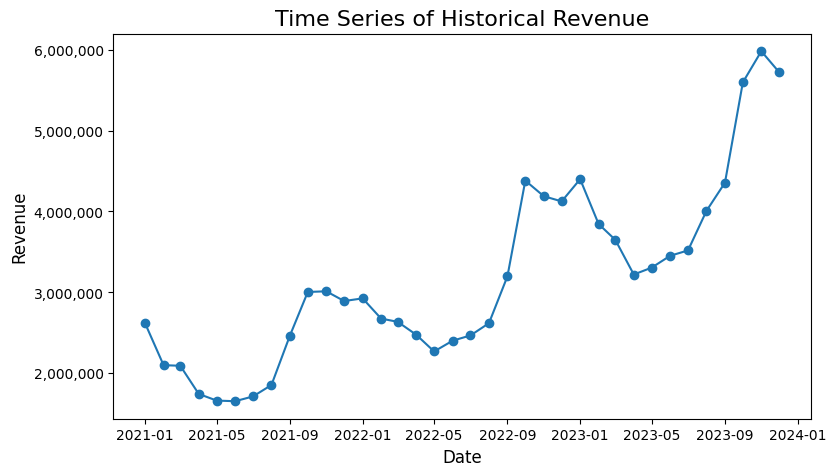

In [441]:
# Plotting the time series of historical revenue in Python

plt.figure(figsize=(9, 5))
plt.plot(df_copy['Date'], df_copy['Revenue'], marker='o', linestyle='-')
plt.title('Time Series of Historical Revenue', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()

<center> Section One: Perform Statistical/Diagnostic Test of Time Series Data </center>

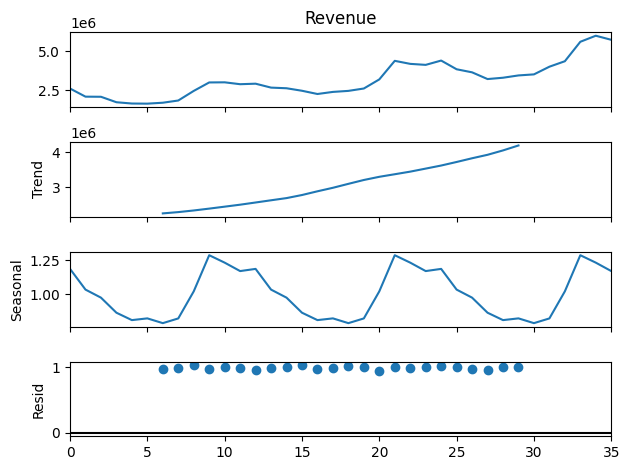

In [442]:
#  Seasonality and Trend - Seasonal Decomposition of Time Series (STL)
# Decompose the time series

decomposition = seasonal_decompose(df_copy['Revenue'], model='multiplicative', period=12)
decomposition.plot()
plt.show()

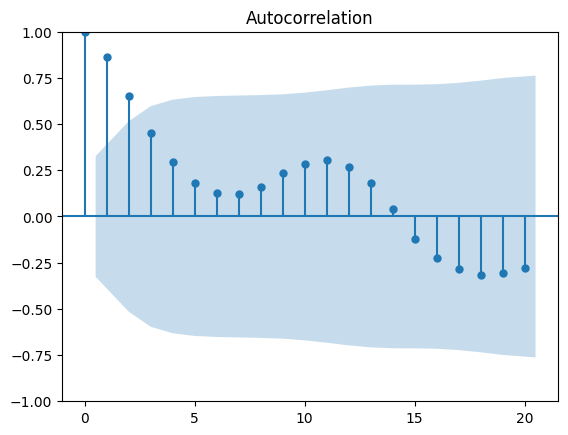

In [443]:
# Autocorrelation - Autocorrelation Function (ACF)
# Plot the autocorrelation function

plot_acf(df_copy['Revenue'], lags=20)
plt.show()

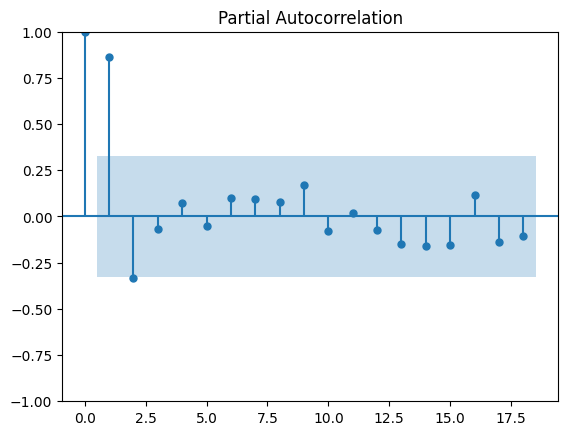

In [444]:
# Plot the partial autocorrelation function
# Adjusting the number of lags for PACF

max_lags = int(len(df_copy) // 2)

# Plot the partial autocorrelation function
plot_pacf(df_copy['Revenue'], lags=max_lags)
plt.show()

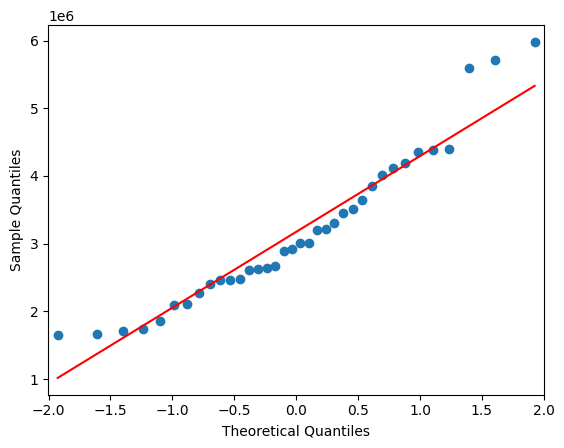

In [445]:
# QQ Plot (Quantile-Quantile Plot)
# Generate a QQ plot for the revenue data

qqplot(df_copy['Revenue'], line='s')
plt.show()

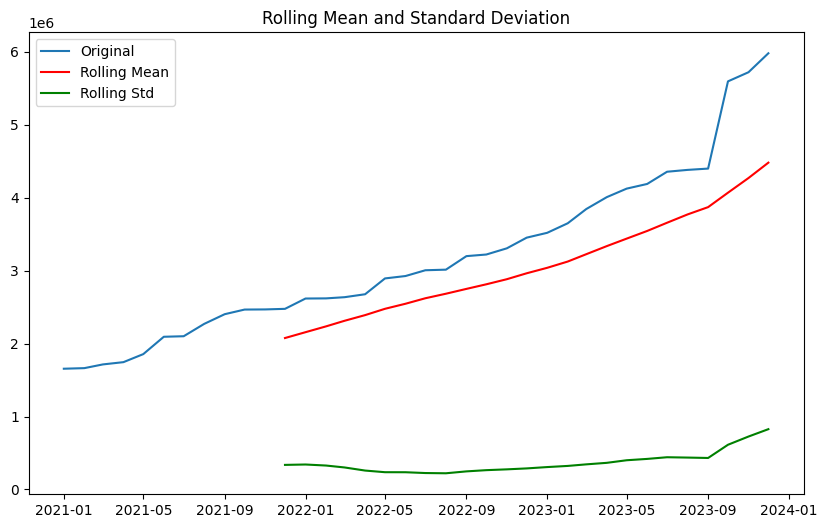

In [446]:
# Rolling Mean and Rolling Standard Deviation Plot

# Calculate the rolling mean and rolling standard deviation
rolling_mean = df_copy['Revenue'].rolling(window=12).mean()
rolling_std = df_copy['Revenue'].rolling(window=12).std()

# Plot the rolling statistics

plt.figure(figsize=(10, 6))
plt.plot(df_copy['Date'], df_copy['Revenue'], label='Original')
plt.plot(df_copy['Date'], rolling_mean, label='Rolling Mean', color='red')
plt.plot(df_copy['Date'], rolling_std, label='Rolling Std', color='green')
plt.title('Rolling Mean and Standard Deviation')
plt.legend()
plt.show()

In [447]:
# Stationarity Test - Augmented Dickey-Fuller (ADF) Test
# Run ADF test on the 'Revenue' column

result = adfuller(df_copy['Revenue'])

# Extract and print the results

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: 2.301205827502677
p-value: 0.9989559474977571
Critical Values: {'1%': np.float64(-3.6461350877925254), '5%': np.float64(-2.954126991123355), '10%': np.float64(-2.6159676124885216)}


In [448]:
# White Noise - Ljung-Box Test
# Ljung-Box test for autocorrelation in residuals

ljung_box_test = acorr_ljungbox(df_copy['Revenue'], lags=[20], return_df=True)

# Print the result of the test

print(ljung_box_test)

       lb_stat     lb_pvalue
20  124.994658  3.364854e-17


In [449]:
# Heteroscedasticity - Engle's ARCH Test
# Engle's ARCH test for heteroscedasticity

arch_test = het_arch(df_copy['Revenue'])

# Print the results

print('ARCH Test Statistic:', arch_test[0])
print('p-value:', arch_test[1])

ARCH Test Statistic: 27.688150023746108
p-value: 0.0002504151504865994


In [450]:
# Calculate skewness and kurtosis

skewness = skew(df_copy['Revenue'])
kurt = kurtosis(df_copy['Revenue'])

print("Skewness:", skewness)
print("Kurtosis:", kurt)

Skewness: 0.798840274390545
Kurtosis: 0.08045082681757032


In [451]:
# Run this code to reset original dataframe

df = pd.read_excel(file_path, sheet_name='Q1.Rev_Projection')
df['Time'] = df['Time'].str.replace('20X1', '2021')
df['Time'] = df['Time'].str.replace('20X2', '2022')
df['Time'] = df['Time'].str.replace('20X3', '2023')
df['Time'] = df['Time'].str.replace('20X4', '2024')
df['Time'] = pd.to_datetime(df['Time'], format='%b %Y')
df.drop(columns=['Projected Revenue'], inplace=True)
df = df.rename(columns={'Historical Revenue': 'Revenue', 'Time': 'Date'})
df = df.dropna()
df_copy = df.copy()

<center> Section Two: Model Development</center>

First Model Selection: Prophet

In [452]:
# Get original data

df_copy = df.copy()

In [453]:
#  Start with a baseline algorithm using Facebook Prophet

df_copy['Date'] = pd.to_datetime(df_copy['Date'])

In [454]:
# Prepare expected column names

df_copy.columns = ['ds', 'y']

In [455]:
# Split the data into training and testing sets (last 6 months for testing)

train, test = df_copy[:-6], df_copy[-6:]

In [456]:
# Set upper and lower bounds for the logistic growth model

cap_value = train['y'].max() * 1.2
train['cap'], train['floor'] = cap_value, 0
df_copy['cap'], df_copy['floor'] = cap_value, 0

In [457]:
# Initialize and fit the model

model = Prophet(growth='logistic', yearly_seasonality=True, changepoint_prior_scale=0.05)
model.fit(train)

00:23:23 - cmdstanpy - INFO - Chain [1] start processing


00:23:24 - cmdstanpy - INFO - Chain [1] done processing


In [458]:
# Backtesting - ensure 'cap' and 'floor' columns exist in the test set

test['cap'], test['floor'] = cap_value, 0
prophet_pred = model.predict(test[['ds', 'cap', 'floor']])

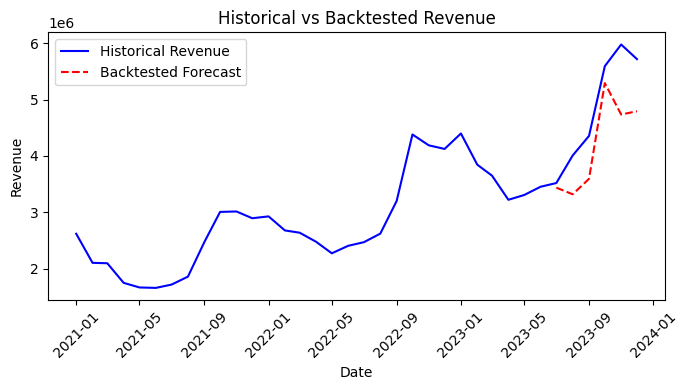

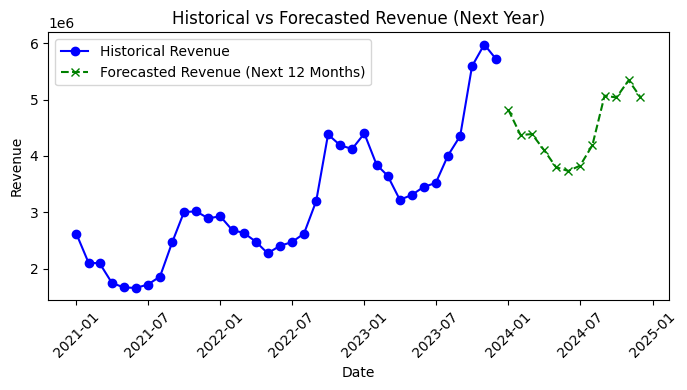

In [459]:
# Plot historical and backtested forecast data

plt.figure(figsize=(7, 4))
plt.plot(df_copy['ds'], df_copy['y'], label='Historical Revenue', color='blue')
plt.plot(prophet_pred['ds'], prophet_pred['yhat'], label='Backtested Forecast', color='red', linestyle='--')
plt.title('Historical vs Backtested Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Forecasting for the next 12 months

future_dates = pd.date_range(df_copy['ds'].max() + pd.DateOffset(months=1), periods=12, freq='MS')
future = pd.DataFrame({'ds': future_dates, 'cap': cap_value, 'floor': 0})
forecast_future = model.predict(future)

# Plot historical and forecasted revenue for the next 12 months

plt.figure(figsize=(7, 4))
plt.plot(df_copy['ds'], df_copy['y'], label='Historical Revenue', color='blue', marker='o', linestyle='-')
plt.plot(forecast_future['ds'], forecast_future['yhat'], label='Forecasted Revenue (Next 12 Months)', color='green', marker='x', linestyle='--')
plt.title('Historical vs Forecasted Revenue (Next Year)')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Second Model: Holts-Winter

In [460]:
# Get original data

df_copy = df.copy()

In [461]:
# Convert 'Date' column to datetime and set as index

df_copy['Date'] = pd.to_datetime(df_copy['Date'])
df_copy.set_index('Date', inplace=True)

In [462]:
# Define the number of periods for backtesting (approx. 6 months)

backtest_periods = 6

In [463]:
# Split data into training and test sets

train_data, test_data = df_copy[:-backtest_periods], df_copy[-backtest_periods:]


In [464]:
# Initialize and fit the Holt-Winters model

model = ExponentialSmoothing(
    train_data['Revenue'], trend='add', seasonal='mul', seasonal_periods=12
).fit()

In [465]:
# Make predictions for the test period (last 6 months) and forecast the next 12 months

holts_wint_pred = model.forecast(steps=len(test_data))
forecast_12_months = model.forecast(steps=12)

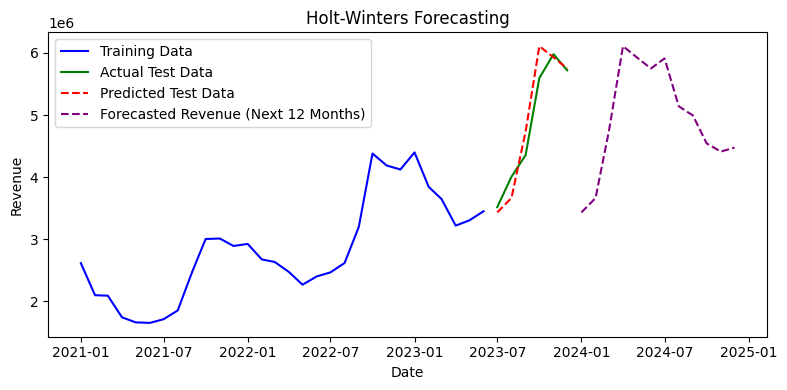

In [466]:
# Plot results
plt.figure(figsize=(8, 4))
plt.plot(train_data.index, train_data['Revenue'], label='Training Data', color='blue')
plt.plot(test_data.index, test_data['Revenue'], label='Actual Test Data', color='green')
plt.plot(test_data.index, holts_wint_pred, label='Predicted Test Data', color='red', linestyle='--')

# Create future index for 12-month forecast
forecast_index = pd.date_range(start=test_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
holtwinter_12_month_forecast = pd.DataFrame({
    'ds': forecast_index,
    'holtwinter_forecast': forecast_12_months
})

plt.plot(forecast_index, forecast_12_months, label='Forecasted Revenue (Next 12 Months)', color='purple', linestyle='--')

# Add labels and display
plt.title('Holt-Winters Forecasting')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.tight_layout()
plt.show()

Third Model: GBR

In [467]:
# Get original data

df_copy = df.copy()

In [468]:
# Prepare Data

df_copy['Month'] = df_copy['Date'].dt.month
df_copy['Year'] = df_copy['Date'].dt.year

In [469]:
# Select features and target

X = df_copy[['Month', 'Year']]
y = df_copy['Revenue']

In [470]:
# Split the data into training and testing sets (last 6 months for testing)

X_train, X_test = X[:-6], X[-6:]
y_train, y_test = y[:-6], y[-6:]

In [471]:
# Create and tune the GradientBoostingRegressor using GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.5, 1.0],
    'max_depth': [3, 4, 5]
}
grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.1, 0.5, 1.0],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [472]:
# Train the model with the best parameters

best_params = grid_search.best_params_
model = GradientBoostingRegressor(**best_params, random_state=42)
model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.5, random_state=42)

In [473]:
# Predict revenue for the test set

gbr_pred = model.predict(X_test)

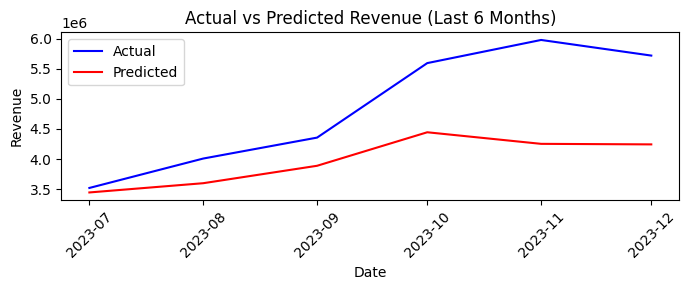

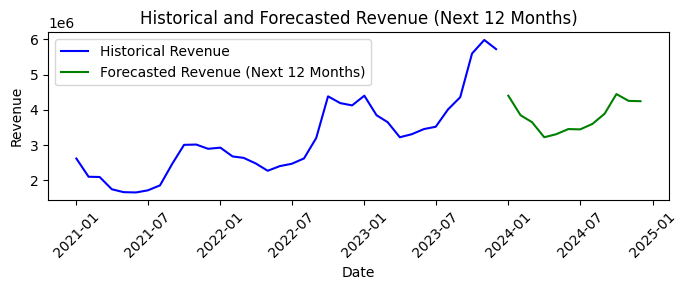

In [474]:
# Plot actual vs predicted revenue for the test set

plt.figure(figsize=(7, 3))
plt.plot(df_copy['Date'][-6:], y_test, label='Actual', color='blue')
plt.plot(df_copy['Date'][-6:], gbr_pred, label='Predicted', color='red')
plt.title('Actual vs Predicted Revenue (Last 6 Months)')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Forecast revenue for the next 12 months

last_date = df_copy['Date'].max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')
X_future = pd.DataFrame({'Month': future_dates.month, 'Year': future_dates.year})
y_future_pred = model.predict(X_future)

# Create a DataFrame for the 12-month forecast

gbr_12_month_forecast = pd.DataFrame({
    'Date': future_dates,
    'gbr_forecast': y_future_pred
})


# Plot historical data and future forecast

plt.figure(figsize=(7, 3))
plt.plot(df_copy['Date'], df_copy['Revenue'], label='Historical Revenue', color='blue')
plt.plot(future_dates, y_future_pred, label='Forecasted Revenue (Next 12 Months)', color='green')
plt.title('Historical and Forecasted Revenue (Next 12 Months)')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<center>Section Three: Evaluation Metrics for Model</center>

In [475]:
# Look at the variable type of the predictions

print(type(holts_wint_pred), type(prophet_pred), type(gbr_pred))

<class 'pandas.core.series.Series'> <class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [476]:
# Convert Holt-Winters Series to DataFrame

holts_wint_pred = holts_wint_pred.reset_index(drop=True)
holts_wint_pred_df = pd.DataFrame(holts_wint_pred, columns=['Holt-Winters'])

In [477]:
# Extract Prophet forecast from DataFrame

prophet_pred_df = prophet_pred[['yhat']].rename(columns={'yhat': 'Prophet'}).reset_index(drop=True)

In [478]:
# Convert GBR Array to DataFrame

gbr_pred_df = pd.DataFrame(gbr_pred, columns=['GBR']).reset_index(drop=True)

In [479]:
# Define y_true as the 'Revenue' column from the test_data

y_true = test_data['Revenue'].values

In [480]:
# Ensure all have the same length (matching y_true)

length = len(y_true)
holts_wint_pred_df = holts_wint_pred_df[:length]
prophet_pred_df = prophet_pred_df[:length]
gbr_pred_df = gbr_pred_df[:length]

In [481]:
# Create a DataFrame with the actual and predicted values for each model

df_predictions = pd.DataFrame({
    'Date': test_data.index[:length],
    'Actual': y_true[:length]
})

In [482]:
# Concatenate the predictions

df_predictions = pd.concat([df_predictions, holts_wint_pred_df, prophet_pred_df, gbr_pred_df], axis=1)

In [483]:
# Extract the actual and predicted values from the DataFrame

y_true = df_predictions['Actual']
y_holt = df_predictions['Holt-Winters']
y_prophet = df_predictions['Prophet']
y_gbr = df_predictions['GBR']

In [484]:
# Compute MAE, MSE, RMSE, MAPE, and R-squared for each model

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_true, y_pred)
    mape = (abs((y_true - y_pred) / y_true).mean()) * 100
    return mae, mse, rmse, mape, r2

In [485]:
# Evaluate each model

holt_metrics = evaluate_model(y_true, y_holt)
prophet_metrics = evaluate_model(y_true, y_prophet)
gbr_metrics = evaluate_model(y_true, y_gbr)

In [486]:
# Print evaluation metrics for each model

print(f"""
Holt-Winters Metrics:
---------------------
MAE:  {holt_metrics[0]:.2f}
MSE:  {holt_metrics[1]:.2f}
RMSE: {holt_metrics[2]:.2f}
MAPE: {holt_metrics[3]:.2f}%
R2:   {holt_metrics[4]:.2f}

Prophet Metrics:
----------------
MAE:  {prophet_metrics[0]:.2f}
MSE:  {prophet_metrics[1]:.2f}
RMSE: {prophet_metrics[2]:.2f}
MAPE: {prophet_metrics[3]:.2f}%
R2:   {prophet_metrics[4]:.2f}

GBR Metrics:
------------
MAE:  {gbr_metrics[0]:.2f}
MSE:  {gbr_metrics[1]:.2f}
RMSE: {gbr_metrics[2]:.2f}
MAPE: {gbr_metrics[3]:.2f}%
R2:   {gbr_metrics[4]:.2f}
""")


Holt-Winters Metrics:
---------------------
MAE:  233296.98
MSE:  89245761663.15
RMSE: 298740.29
MAPE: 5.03%
R2:   0.90

Prophet Metrics:
----------------
MAE:  667465.96
MSE:  593113865443.74
RMSE: 770138.86
MAPE: 13.23%
R2:   0.33

GBR Metrics:
------------
MAE:  884788.78
MSE:  1147240883992.41
RMSE: 1071093.31
MAPE: 16.40%
R2:   -0.30



In [487]:
# Calculate percentage errors for each model

df_predictions['Holt-Winters % Error'] = (df_predictions['Holt-Winters'] - df_predictions['Actual']) / df_predictions['Actual'] * 100
df_predictions['Prophet % Error'] = (df_predictions['Prophet'] - df_predictions['Actual']) / df_predictions['Actual'] * 100
df_predictions['GBR % Error'] = (df_predictions['GBR'] - df_predictions['Actual']) / df_predictions['Actual'] * 100

In [488]:
# Look at the dataframe with the new percentages

df_predictions

,Date,Actual,Holt-Winters,Prophet,GBR,Holt-Winters % Error,Prophet % Error,GBR % Error
0,2023-07-01,3518642.0,3.432980e+06,3.436315e+06,3.443790e+06,-2.434527,-2.339731,-2.127298
1,2023-08-01,4007704.0,3.665580e+06,3.318704e+06,3.597505e+06,-8.536653,-17.191876,-10.235274
2,2023-09-01,4355934.0,4.734545e+06,3.593117e+06,3.887363e+06,8.691848,-17.512126,-10.757069
3,2023-10-01,5595042.0,6.109257e+06,5.294314e+06,4.444716e+06,9.190539,-5.374902,-20.559743
4,2023-11-01,5979934.0,5.930579e+06,4.735956e+06,4.252144e+06,-0.825337,-20.802530,-28.893126
5,2023-12-01,5720131.0,5.749946e+06,4.794184e+06,4.243137e+06,0.521238,-16.187520,-25.820986


In [489]:
# Calculate the mean (average) percentage error for each model

print(f"The average percentage error for Holt-Winters is: {df_predictions['Holt-Winters % Error'].mean():.2f}%")
print(f"The average percentage error for Prophet is: {df_predictions['Prophet % Error'].mean():.2f}%")
print(f"The average percentage error for GBR is: {df_predictions['GBR % Error'].mean():.2f}%")

The average percentage error for Holt-Winters is: 1.10%
The average percentage error for Prophet is: -13.23%
The average percentage error for GBR is: -16.40%


<center> Final Graph </center>

In [490]:
# Select data

df_copy = df.copy()
df_copy = df_copy.rename(columns={'Date': 'ds', 'Revenue': 'y'})

In [491]:
# Prepare the historical data

historical_df = df_copy[['ds', 'y']].copy()
historical_df['model'] = 'Historical'

In [492]:
# Forecasting the next 12 months (Prophet)

future_dates_prophet = pd.date_range(df_copy['ds'].max() + pd.DateOffset(months=1), periods=12, freq='MS')
prophet_forecast_df = forecast_future[['ds', 'yhat']].copy()
prophet_forecast_df = prophet_forecast_df.rename(columns={'yhat': 'Revenue'})
prophet_forecast_df['model'] = 'Prophet'

In [493]:
# Forecasting the next 12 months (Holts-Winters)

forecast_index_hw = pd.date_range(start=test_data.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
holts_wint_forecast_df = pd.DataFrame({'ds': forecast_index_hw, 'Revenue': forecast_12_months})
holts_wint_forecast_df['model'] = 'Holt-Winters'

In [494]:
# Forecasting the next 12 months (GBR)

gbr_future_df = pd.DataFrame({'ds': future_dates_prophet, 'Revenue': model.predict(pd.DataFrame({
    'Month': future_dates_prophet.month, 'Year': future_dates_prophet.year}))})
gbr_future_df['model'] = 'GBR'

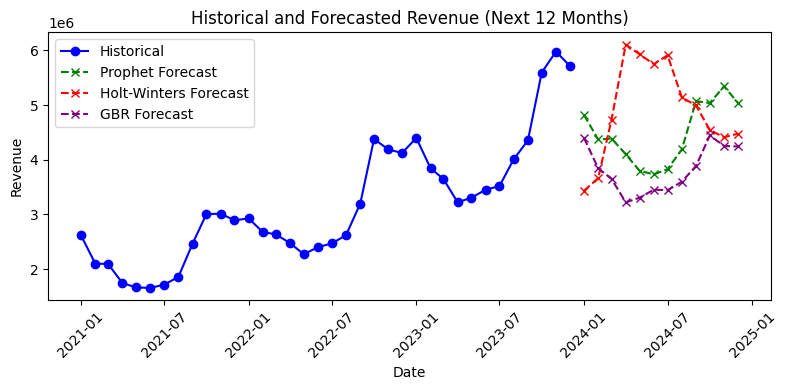

In [495]:
# Concatenate historical and future predictions

all_predictions = pd.concat([historical_df, prophet_forecast_df, holts_wint_forecast_df, gbr_future_df], axis=0)
plt.figure(figsize=(8, 4))
plt.plot(historical_df['ds'], historical_df['y'], label='Historical', color='blue', marker='o')
plt.plot(prophet_forecast_df['ds'], prophet_forecast_df['Revenue'], label='Prophet Forecast', color='green', linestyle='--', marker='x')
plt.plot(holts_wint_forecast_df['ds'], holts_wint_forecast_df['Revenue'], label='Holt-Winters Forecast', color='red', linestyle='--', marker='x')
plt.plot(gbr_future_df['ds'], gbr_future_df['Revenue'], label='GBR Forecast', color='purple', linestyle='--', marker='x')
plt.title('Historical and Forecasted Revenue (Next 12 Months)')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()